# Objetivos

*  Desarrollar un nuevo enfoque de pronóstico para mejorar la precisión de las predicciones de ventas de productos de DSMarket.
*  Actualmente dependen de enfoques rudimentarios.
*  Empezar pronosticando las ventas a nivel de **tienda-producto**, y obtener las **ventas agregadas por departamento/tienda/ciudad** sumando los pronósticos independientes. Evaluar si este sigue siendo un enfoque válido.

*  Comenzar con **pronósticos de 28 días** (4 semanas) como prueba inicial.
Para un problema de pronóstico de ventas como este, recomendaría utilizar una serie temporal sobre un **modelo de regresión**, por las siguientes razones:
Los datos de ventas tienen una fuerte componente temporal seriada - las ventas en un día o semana están altamente correlacionadas con las ventas en periodos recientes. Un modelo de serie temporal captura mejor esta autocorrelación.


# Librerías


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.preprocessing import OrdinalEncoder
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import xgboost as xgb

pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)

# Cargar datos

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_forecast = pd.read_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/3. Sales Forecasting/Datos/forecast.csv')
df_forecast.head(2)

,date,id,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month
0,2011-01-30,ACCESORIES_1_001_NYC_1,1,1,3,0,1,11.012579,0,600,0,4,2011,1,1
1,2011-01-30,ACCESORIES_1_002_NYC_1,2,1,3,0,1,5.280100,0,493,0,4,2011,1,1


In [ ]:
df_forecast = pd.read_csv('/content/drive/MyDrive/codigo/3. Sales Forecasting/Datos/forecast.csv')
df_forecast.head(2)

,date,id,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month
0,2011-01-30,ACCESORIES_1_001_NYC_1,1,1,3,0,1,11.012579,0,600,0,4,2011,1,1
1,2011-01-30,ACCESORIES_1_002_NYC_1,2,1,3,0,1,5.280100,0,493,0,4,2011,1,1


# EDA

In [ ]:
df_forecast['date'] = pd.to_datetime(df_forecast['date'], format='%Y-%m-%d')

In [ ]:
df_forecast.describe().T

,count,mean,min,25%,50%,75%,max,std
date,8354260,2013-09-11 12:00:00.000003072,2011-01-30 00:00:00,2012-05-20 00:00:00,2013-09-11 12:00:00,2015-01-04 00:00:00,2016-04-24 00:00:00,NaN
item,8354260.0,269.477534,1.0,111.0,235.0,388.0,827.0,194.416759
region,8354260.0,1.0,0.0,0.0,1.0,2.0,2.0,0.774597
store,8354260.0,4.5,0.0,2.0,4.5,7.0,9.0,2.872281
category,8354260.0,1.285995,0.0,1.0,1.0,2.0,2.0,0.758166
department,8354260.0,1.88816,1.0,1.0,2.0,3.0,3.0,0.799488
price,8354260.0,5.568324,0.228,2.625892,4.176,7.176,40.607204,4.541449
sales,8354260.0,7.863702,0.0,0.0,2.0,7.0,3976.0,23.680201
total_sales,8354260.0,2154.65428,10.0,355.0,848.0,2032.0,250502.0,5217.141193
event,8354260.0,0.113139,0.0,0.0,0.0,0.0,1.0,0.316762


In [ ]:
df_forecast.sort_values(["id", "date"], ascending = True, inplace = True)
df_forecast.head(2)

,date,id,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month
12196,2011-01-30,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,0,4,2011,1,1
42686,2011-02-06,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,1,5,2011,2,2


In [ ]:
# NOTA: Esto es opcional si quieren que el código vaya más rápido, y además se obtiene un leve mejor RMSE
df_forecast= df_forecast[df_forecast['date'] > '2012-12-31']

# Build Features

In [ ]:
# Revenue y lag_1 de revenue
df_forecast['revenue']= df_forecast['sales'] * df_forecast['price']
df_forecast['id_revenue_mean_lag_1'] = df_forecast.groupby(["id"])["revenue"].transform(lambda series: series.shift(1))

# Sales lag_1 y diferencia de sales de 1 semana
df_forecast['id_sales_sum_lag_1'] = df_forecast.groupby(["id"])["sales"].transform(lambda series: series.shift(1))
df_forecast['dif_sales_1w'] = df_forecast['id_sales_sum_lag_1'] - df_forecast['sales']

# Sales lag_4 y diferencia de sales de 4 semanas
df_forecast['id_sales_sum_lag_4'] = df_forecast.groupby(["id"])["sales"].transform(lambda series: series.shift(4))
df_forecast['dif_sales_4w'] = df_forecast['id_sales_sum_lag_4'] - df_forecast['sales']

# Price lag_4 y diferencia de price de 4 semanas
df_forecast['id_price_lag_4'] = df_forecast.groupby(["id"])["price"].transform(lambda series: series.shift(4))
df_forecast['dif_price_4w'] = df_forecast['id_price_lag_4'] - df_forecast['price']

df_forecast.head(2)

,date,id,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,id_sales_sum_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w
3091686,2013-01-06,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,1,1,2013,1,25,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3122176,2013-01-13,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,0,2,2013,1,25,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN


In [ ]:
# Función para crear lags de variables agrupadas
def build_ts_vars(df, gb_list, target_column, agg_func, agg_func_name):
    assert "date" in df.columns.tolist(), "Date must be in df columns"
    new_name = "_".join(gb_list + [target_column] + [agg_func_name])

    gb_df_ = (
        df
        .set_index("date")
        .groupby(gb_list)
        .resample('W')[target_column]
        .apply(agg_func)
        .to_frame()
        .reset_index()
        .rename(
            columns = {
                target_column : new_name
            }
        )
    )
    gb_df_[f"{new_name}_lag_1"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(1)
    )
    gb_df_[f"{new_name}_lag_2"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(2)
    )
    gb_df_[f"{new_name}_lag_3"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(3)
    )
    gb_df_[f"{new_name}_lag_4"] = gb_df_.groupby(gb_list)[new_name].transform(
        lambda series: series.shift(4)
    )
    print(f"Plus 4 lags for: {new_name}")
    gb_df_.drop(new_name, inplace = True, axis = 1)

    return gb_df_

In [ ]:
print(f'Dimensión inicial df_forecast: {df_forecast.shape}')
# Suma de ventas agrupadas por store e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["store","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# Promedio de revenue agrupado por store e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["store","item"],
    target_column = "revenue",
    agg_func = np.mean,
    agg_func_name =  "mean")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["store","item"], how = "left")

# Suma de ventas agrupadas por region e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["region","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["region","item"], how = "left")

# Suma de ventas agrupadas por category e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["category","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name =  "sum")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["category","item"], how = "left")

# Suma de ventas agrupadas por department e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["department","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name =  "sum")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["department","item"], how = "left")

# Promedio de ventas agrupadas por item y evento
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["event","item"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name = "mean")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["event","item"], how = "left")

# Suma de ventas agrupadas por category, store e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["category","store","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["category","store","item"], how = "left")

# Suma de ventas agrupadas por category, department e item
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["category","department","item"],
    target_column = "sales",
    agg_func = np.sum,
    agg_func_name = "sum")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["category","department","item"], how = "left")

# Promedio de ventas agrupado por category, event, item y region
vars_ts_ = build_ts_vars(
    df = df_forecast,
    gb_list = ["category","event","item","region"],
    target_column = "sales",
    agg_func = np.mean,
    agg_func_name =  "mean")
df_forecast = pd.merge(df_forecast, vars_ts_, on = ["date"] + ["category","event","item","region"], how = "left")

print(f'Dimensión final df_forecast: {df_forecast.shape}')
df_forecast.head()

Dimensión inicial df_forecast: (5274770, 23)
Plus 4 lags for: store_item_sales_sum
Plus 4 lags for: store_item_revenue_mean
Plus 4 lags for: region_item_sales_sum
Plus 4 lags for: category_item_sales_sum
Plus 4 lags for: department_item_sales_sum
Plus 4 lags for: event_item_sales_mean
Plus 4 lags for: category_store_item_sales_sum
Plus 4 lags for: category_department_item_sales_sum
Plus 4 lags for: category_event_item_region_sales_mean
Dimensión final df_forecast: (5274770, 59)


,date,id,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,id_sales_sum_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4
0,2013-01-06,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,1,1,2013,1,25,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-13,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,0,2,2013,1,25,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,11.097333,NaN,NaN,NaN,62.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-20,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,0,3,2013,1,25,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,18.0,27.0,NaN,NaN,8.590587,11.097333,NaN,NaN,59.0,62.0,NaN,NaN,3.0,7.0,NaN,NaN,64.0,60.0,NaN,NaN,2.514286,NaN,NaN,NaN,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,0.166667,NaN,NaN,NaN
3,2013-01-27,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,0,4,2013,1,25,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,14.0,18.0,27.0,NaN,6.526073,8.590587,11.097333,NaN,43.0,59.0,62.0,NaN,6.0,3.0,7.0,NaN,56.0,64.0,60.0,NaN,2.185714,2.514286,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0,0.0,NaN,0.166667,0.166667,NaN,NaN
4,2013-02-03,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,0,260,1,5,2013,2,26,0.0,0.0,0.0,0.0,0.0,0.0,10.968483,0.0,18.0,14.0,18.0,27.0,9.387707,6.526073,8.590587,11.097333,54.0,43.0,59.0,62.0,6.0,6.0,3.0,7.0,63.0,56.0,64.0,60.0,NaN,NaN,NaN,2.642857,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.5


# Borrar features que no serán parte del modelo

In [ ]:
df_forecast1 = df_forecast.copy()

In [ ]:
COLUMNS_TO_DROP = ["id_sales_sum_lag_1"]
df_forecast1.drop(COLUMNS_TO_DROP, inplace = True, axis = 1)

In [ ]:
df_forecast1.set_index("id", inplace = True)
df_forecast1.sample(3)

,date,item,region,store,category,department,price,sales,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_330_BOS_1,2013-09-08,330,0,0,0,1,9.855729,0,1294,0,36,2013,9,33,0.0,49.278645,5.0,2.0,2.0,9.855729,0.0,11.0,7.0,10.0,12.0,15.467290,9.621618,14.614181,13.262034,42.0,33.0,53.0,50.0,80.0,68.0,85.0,81.0,80.0,68.0,85.0,81.0,4.70,4.420000,5.30,5.020000,5.0,3.0,5.0,2.0,80.0,68.0,85.0,81.0,3.666667,1.666667,4.0,5.000
SUPERMARKET_2_243_PHI_1,2013-09-29,243,2,7,2,2,9.035226,0,493,0,39,2013,9,33,0.0,0.000000,0.0,0.0,0.0,9.035226,0.0,25.0,13.0,29.0,21.0,11.582119,5.915580,23.394320,13.448691,66.0,48.0,89.0,58.0,25.0,31.0,62.0,27.0,6.0,7.0,9.0,11.0,4.60,4.080000,6.44,4.720000,6.0,4.0,4.0,2.0,0.0,1.0,0.0,3.0,1.500000,2.000000,3.0,0.500
HOME_&_GARDEN_2_155_NYC_4,2015-03-22,155,1,6,1,2,8.212500,0,452,0,12,2015,3,51,0.0,8.212500,1.0,0.0,0.0,8.212500,0.0,27.0,22.0,20.0,23.0,42.504520,31.607812,43.102262,43.243683,140.0,127.0,140.0,124.0,63.0,66.0,64.0,48.0,91.0,77.0,45.0,19.0,5.35,5.083333,4.40,4.216667,5.0,4.0,3.0,5.0,24.0,25.0,25.0,19.0,3.875000,4.375000,4.5,3.125


# Train Test Split

In [ ]:
# Asignar el valor 0 a las fechas que se van a predecir, cuatro últimas semanas (Y_test):
dates_to_replace = ['2016-04-03', '2016-04-10', '2016-04-17', '2016-04-24']
df_forecast1.loc[df_forecast1['date'].isin(dates_to_replace), 'sales'] = 0

In [ ]:
weeks = sorted(list(df_forecast1["date"].unique()))

train_index = weeks[:-10]
valida_index = weeks[-10:-4]
test_index = weeks[-4:]

X_train = df_forecast1[df_forecast1["date"].isin(train_index)].drop(['sales', "date"], axis=1)
Y_train = df_forecast1[df_forecast1["date"].isin(train_index)]['sales']

X_valida = df_forecast1[df_forecast1["date"].isin(valida_index)].drop(['sales', "date"], axis=1)
Y_valida = df_forecast1[df_forecast1["date"].isin(valida_index)]['sales']

X_test = df_forecast1[df_forecast1["date"].isin(test_index)].drop(['sales', "date"], axis = 1)
Y_test = df_forecast1[df_forecast1["date"].isin(test_index)]['sales']

print(f"Nuestro índice de entrenamiento es {train_index[:2]} - ... - {train_index[-2:]}\n")
print(f"Nuestro índice de validación es {valida_index}\n")
print(f"Nuestro índice de prueba es {test_index}\n")

Nuestro índice de entrenamiento es [Timestamp('2013-01-06 00:00:00'), Timestamp('2013-01-13 00:00:00')] - ... - [Timestamp('2016-02-07 00:00:00'), Timestamp('2016-02-14 00:00:00')]

Nuestro índice de validación es [Timestamp('2016-02-21 00:00:00'), Timestamp('2016-02-28 00:00:00'), Timestamp('2016-03-06 00:00:00'), Timestamp('2016-03-13 00:00:00'), Timestamp('2016-03-20 00:00:00'), Timestamp('2016-03-27 00:00:00')]

Nuestro índice de prueba es [Timestamp('2016-04-03 00:00:00'), Timestamp('2016-04-10 00:00:00'), Timestamp('2016-04-17 00:00:00'), Timestamp('2016-04-24 00:00:00')]



In [ ]:
print(f'Train shape: {X_train.shape}, Valida shape: {X_valida.shape}, Test shape: {X_test.shape}')

Train shape: (4969870, 55), Valida shape: (182940, 55), Test shape: (121960, 55)


In [ ]:
X_train.head(2)

,item,region,store,category,department,price,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,1,1,2013,1,25,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,2,2013,1,25,0.0,0.0,0.0,NaN,NaN,NaN,NaN,27.0,NaN,NaN,NaN,11.097333,NaN,NaN,NaN,62.0,NaN,NaN,NaN,7.0,NaN,NaN,NaN,60.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
X_test.head(2)

,item,region,store,category,department,price,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,13,2016,4,64,21.936966,21.936966,0.0,3.0,1.0,10.968483,0.0,12.0,16.0,19.0,16.0,8.900633,9.517536,13.936788,10.609232,56.0,67.0,63.0,54.0,55.0,47.0,40.0,39.0,126.0,115.0,108.0,94.0,NaN,4.057143,4.371429,4.214286,3.0,2.0,3.0,3.0,51.0,41.0,37.0,37.0,NaN,1.333333,1.833333,1.166667
ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,14,2016,4,64,21.936966,21.936966,0.0,3.0,1.0,10.968483,0.0,11.0,12.0,16.0,19.0,6.841991,8.900633,9.517536,13.936788,49.0,56.0,67.0,63.0,44.0,55.0,47.0,40.0,98.0,126.0,115.0,108.0,3.442857,NaN,4.057143,4.371429,2.0,3.0,2.0,3.0,40.0,51.0,41.0,37.0,1.333333,NaN,1.333333,1.833333


In [ ]:
Y_test.sum()  # debe ser 0

0

# Model Train

In [ ]:
model = xgb.XGBRegressor(seed=175)

model.fit(
     X_train,
     Y_train,
     eval_metric = "rmse",
     eval_set = [(X_train, Y_train), (X_valida, Y_valida)],
     verbose = True,
     early_stopping_rounds = 15
     )

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-rmse:17.20064	validation_1-rmse:15.94272
[1]	validation_0-rmse:12.89260	validation_1-rmse:11.58409
[2]	validation_0-rmse:10.03005	validation_1-rmse:8.66981
[3]	validation_0-rmse:8.07266	validation_1-rmse:6.68439
[4]	validation_0-rmse:6.74692	validation_1-rmse:5.38178
[5]	validation_0-rmse:5.70245	validation_1-rmse:4.50929
[6]	validation_0-rmse:5.08351	validation_1-rmse:3.99956
[7]	validation_0-rmse:4.61300	validation_1-rmse:3.68345
[8]	validation_0-rmse:4.31349	validation_1-rmse:3.45550
[9]	validation_0-rmse:4.10668	validation_1-rmse:3.34660
[10]	validation_0-rmse:3.96253	validation_1-rmse:3.23384
[11]	validation_0-rmse:3.87131	validation_1-rmse:3.17629
[12]	validation_0-rmse:3.78807	validation_1-rmse:3.13521
[13]	validation_0-rmse:3.71251	validation_1-rmse:3.07855
[14]	validation_0-rmse:3.61099	validation_1-rmse:3.02562
[15]	validation_0-rmse:3.55844	validation_1-rmse:3.00250
[16]	validation_0-rmse:3.53260	validation_1-rmse:2.98182
[17]	validation_0-rmse:3.47670	valid

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

# Features Importance

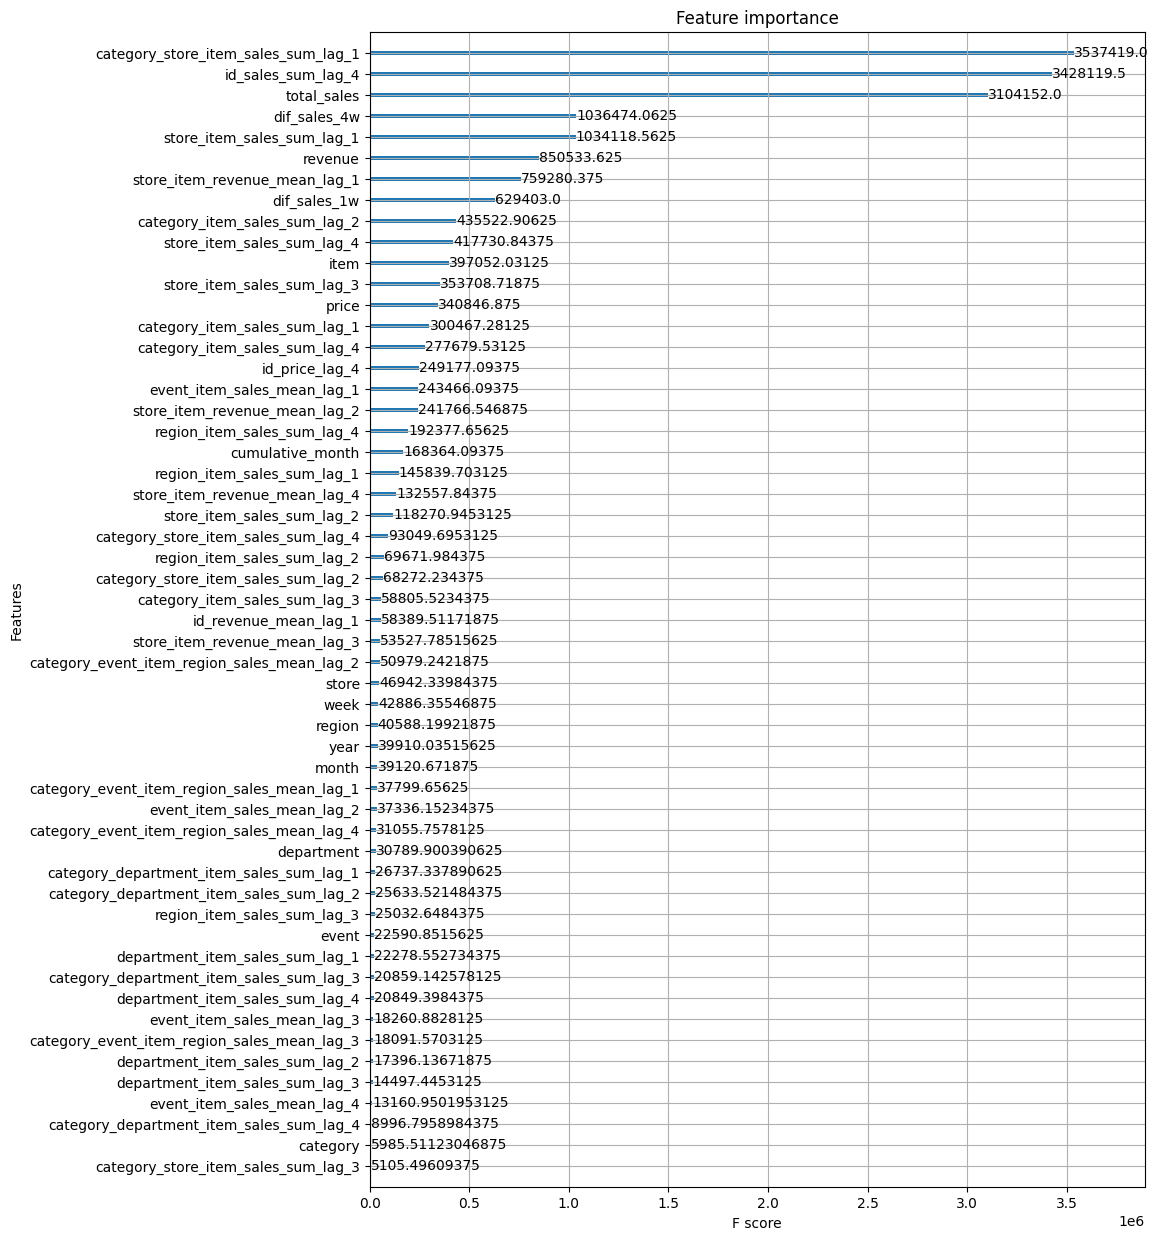

In [ ]:
fig, ax = plt.subplots(figsize = (10, 15))
xgb.plot_importance(model, importance_type = "gain", ax = ax);

# Model Predict

In [ ]:

Y_train_predict = model.predict(X_train).clip(0,3976)
Y_valida_predict = model.predict(X_valida).clip(0,3976)

rmse_train = np.sqrt(
    mean_squared_error(
        y_true = Y_train,
        y_pred = Y_train_predict
    )
)

rmse_valida = np.sqrt(
    mean_squared_error(
        y_true = Y_valida,
        y_pred = Y_valida_predict
    )
)

rmse_train= str(round(rmse_train, 3)).replace(".", "_")
rmse_valida = str(round(rmse_valida, 3)).replace(".", "_")

print(f"Train RMSE: {rmse_train}")
print(f"Validation RMSE: {rmse_valida}")

Train RMSE: 2_293
Validation RMSE: 2_216


# Model Evaluations

### Evaluación del Error

RMSE: 2.216
MAE: 0.5777
R2-Score: 98.98%


<ipython-input-28-c04386a21939>:12: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(error).set_title('Distribucion Error')


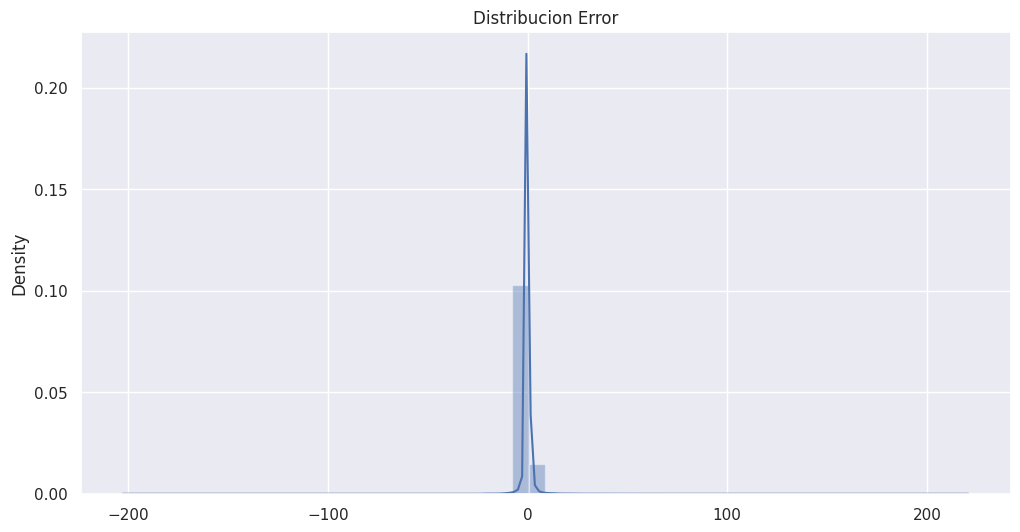

In [ ]:
error = Y_valida_predict - Y_valida.values

mae = np.mean(np.abs(error))
mse = np.mean(error**2)
rmse = np.sqrt(np.mean(error**2))

print('RMSE:', round(rmse,4))
print('MAE:', round(mae,4))
print('R2-Score: {:.2%}'.format(r2_score(Y_valida, Y_valida_predict)))

sns.set(rc={'figure.figsize':(12,6)})
sns.distplot(error).set_title('Distribucion Error')
plt.show()

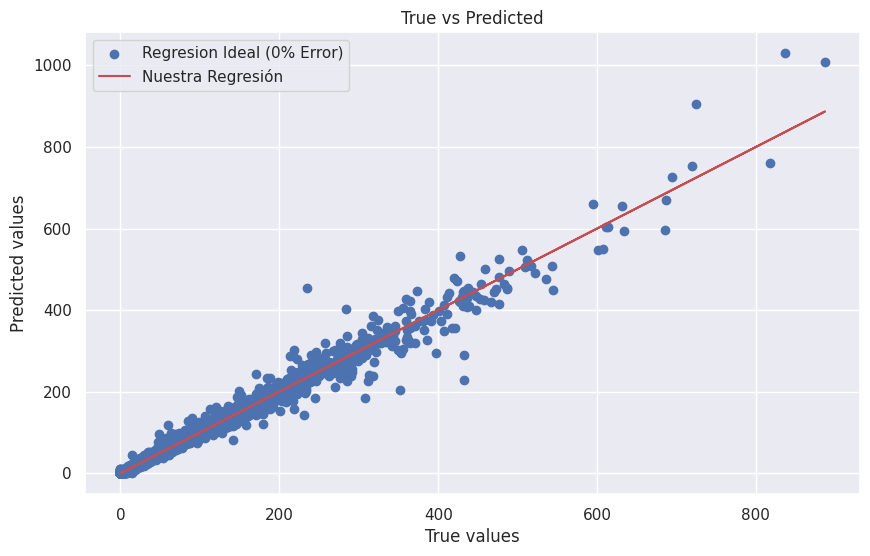

In [ ]:
#Compara Prediccion vs dato real
plt.figure(figsize=[10,6])
plt.scatter(Y_valida, Y_valida_predict)
plt.plot(Y_valida, Y_valida,'r')
plt.title('True vs Predicted')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.legend(['Regresion Ideal (0% Error)','Nuestra Regresión'])
plt.show()

### Intervalo de confianza del Error

In [ ]:
confidence=95
z = (100-confidence)/2
print("Intervalo del error (confianza",confidence,"%):",round(np.percentile(error, 100-z),1),"/",round(np.percentile(error, z),1))

Intervalo del error (confianza 95 %): 2.0 / -2.0


### Predición en datos de validacion

In [ ]:
# Agregar la predicción como una nueva columna al DataFrame X_test
X_valida["sales"] = Y_valida_predict
X_valida.reset_index(inplace = True)
X_valida.head(4)

,id,item,region,store,category,department,price,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4,sales
0,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,7,2016,2,62,21.936966,0.000000,-2.0,2.0,0.0,10.968483,0.0,15.0,16.0,17.0,16.0,8.362325,10.803055,11.232049,12.521825,75.0,65.0,60.0,56.0,49.0,51.0,31.0,50.0,122.0,106.0,90.0,89.0,5.271429,NaN,3.828571,3.557143,0.0,2.0,2.0,3.0,40.0,42.0,25.0,43.0,2.333333,NaN,2.166667,1.833333,2.298662
1,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,8,2016,2,62,21.936966,21.936966,0.0,2.0,0.0,10.968483,0.0,14.0,15.0,16.0,17.0,8.567075,8.362325,10.803055,11.232049,62.0,75.0,65.0,60.0,37.0,49.0,51.0,31.0,118.0,122.0,106.0,90.0,4.528571,5.271429,NaN,3.828571,2.0,0.0,2.0,2.0,31.0,40.0,42.0,25.0,1.833333,2.333333,NaN,2.166667,2.290015
2,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,9,2016,3,63,32.905450,21.936966,-1.0,2.0,-1.0,10.968483,0.0,17.0,14.0,15.0,16.0,15.357823,8.567075,8.362325,10.803055,54.0,62.0,75.0,65.0,45.0,37.0,49.0,51.0,96.0,118.0,122.0,106.0,3.457143,4.528571,5.271429,NaN,3.0,2.0,0.0,2.0,37.0,31.0,40.0,42.0,2.000000,1.833333,2.333333,NaN,2.772890
3,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,10,2016,3,63,32.905450,32.905450,0.0,0.0,-3.0,10.968483,0.0,16.0,17.0,14.0,15.0,10.609232,15.357823,8.567075,8.362325,54.0,54.0,62.0,75.0,39.0,45.0,37.0,49.0,94.0,96.0,118.0,122.0,4.214286,3.457143,4.528571,5.271429,3.0,3.0,2.0,0.0,37.0,37.0,31.0,40.0,1.166667,2.000000,1.833333,2.333333,3.002927


In [ ]:
df_prediction_valida = df_forecast[['date','id','sales']]

In [ ]:
df_prediction_valida= df_prediction_valida[(df_prediction_valida['date'] >'2016-02-20')&(df_prediction_valida['date'] <'2016-03-28')]


In [ ]:
df_prediction_valida.reset_index(inplace = True)

In [ ]:
X_valida = X_valida.rename(columns={'sales': 'sales_predict'})

In [ ]:
df_prediction_valida.tail()

,index,date,id,sales
182935,5274761,2016-02-28,SUPERMARKET_3_827_PHI_3,9
182936,5274762,2016-03-06,SUPERMARKET_3_827_PHI_3,15
182937,5274763,2016-03-13,SUPERMARKET_3_827_PHI_3,8
182938,5274764,2016-03-20,SUPERMARKET_3_827_PHI_3,15
182939,5274765,2016-03-27,SUPERMARKET_3_827_PHI_3,17


In [ ]:
X_valida.tail()

,id,item,region,store,category,department,price,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4,sales_predict
182935,SUPERMARKET_3_827_PHI_3,827,2,9,2,3,1.2,1329,0,8,2016,2,62,10.8,10.8,0.0,12.0,3.0,1.2,0.0,9.0,17.0,9.0,12.0,10.8,20.4,10.8,14.4,61.0,70.0,66.0,54.0,275.0,230.0,144.0,141.0,275.0,230.0,144.0,141.0,27.5,23.0,NaN,14.1,9.0,17.0,9.0,12.0,275.0,230.0,144.0,141.0,20.333333,23.333333,NaN,18.000000,8.158358
182936,SUPERMARKET_3_827_PHI_3,827,2,9,2,3,1.2,1329,0,9,2016,3,63,18.0,10.8,-6.0,9.0,-6.0,1.2,0.0,9.0,9.0,17.0,9.0,10.8,10.8,20.4,10.8,59.0,61.0,70.0,66.0,302.0,275.0,230.0,144.0,302.0,275.0,230.0,144.0,30.2,27.5,23.0,NaN,9.0,9.0,17.0,9.0,302.0,275.0,230.0,144.0,19.666667,20.333333,23.333333,NaN,18.166782
182937,SUPERMARKET_3_827_PHI_3,827,2,9,2,3,1.2,1329,0,10,2016,3,63,9.6,18.0,7.0,17.0,9.0,1.2,0.0,15.0,9.0,9.0,17.0,18.0,10.8,10.8,20.4,72.0,59.0,61.0,70.0,283.0,302.0,275.0,230.0,283.0,302.0,275.0,230.0,28.3,30.2,27.5,23.0,15.0,9.0,9.0,17.0,283.0,302.0,275.0,230.0,24.000000,19.666667,20.333333,23.333333,8.712685
182938,SUPERMARKET_3_827_PHI_3,827,2,9,2,3,1.2,1329,0,11,2016,3,63,18.0,9.6,-7.0,9.0,-6.0,1.2,0.0,8.0,15.0,9.0,9.0,9.6,18.0,10.8,10.8,76.0,72.0,59.0,61.0,262.0,283.0,302.0,275.0,262.0,283.0,302.0,275.0,26.2,28.3,30.2,27.5,8.0,15.0,9.0,9.0,262.0,283.0,302.0,275.0,25.333333,24.000000,19.666667,20.333333,18.343016
182939,SUPERMARKET_3_827_PHI_3,827,2,9,2,3,1.2,1329,1,12,2016,3,63,20.4,18.0,-2.0,9.0,-8.0,1.2,0.0,15.0,8.0,15.0,9.0,18.0,9.6,18.0,10.8,68.0,76.0,72.0,59.0,182.0,262.0,283.0,302.0,182.0,262.0,283.0,302.0,NaN,NaN,NaN,NaN,15.0,8.0,15.0,9.0,182.0,262.0,283.0,302.0,NaN,NaN,NaN,NaN,18.564375


In [ ]:
temp_X_valida = X_valida[['id', 'sales_predict']]
temp_df_prediction_valida = df_prediction_valida[['sales','date']]
df_prediction_valida = pd.concat([temp_X_valida, temp_df_prediction_valida], axis=1)

In [ ]:
df_prediction_valida.head()

,id,sales_predict,sales,date
0,ACCESORIES_1_001_BOS_1,2.298662,2,2016-02-21
1,ACCESORIES_1_001_BOS_1,2.290015,2,2016-02-28
2,ACCESORIES_1_001_BOS_1,2.772890,3,2016-03-06
3,ACCESORIES_1_001_BOS_1,3.002927,3,2016-03-13
4,ACCESORIES_1_001_BOS_1,2.290015,2,2016-03-20


In [ ]:
df_prediction_valida.tail()

,id,sales_predict,sales,date
182935,SUPERMARKET_3_827_PHI_3,8.158358,9,2016-02-28
182936,SUPERMARKET_3_827_PHI_3,18.166782,15,2016-03-06
182937,SUPERMARKET_3_827_PHI_3,8.712685,8,2016-03-13
182938,SUPERMARKET_3_827_PHI_3,18.343016,15,2016-03-20
182939,SUPERMARKET_3_827_PHI_3,18.564375,17,2016-03-27


In [ ]:
# Guardar predicciones
df_prediction_valida.to_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/3. Sales Forecasting/Datos/VALIDA_PREDICT.csv', index=False)

In [ ]:
# Solo los 100 productos con mas ventas
ventas_por_id = df_prediction_valida.groupby('id')['sales'].sum().reset_index()
# Ordenar en orden descendente según las ventas y seleccionar los primeros 100 IDs
top_100_ids = ventas_por_id.nlargest(100, 'sales')['id']
# Filtrar prediction para mantener solo las filas con los IDs seleccionados
prediction_top_100 = df_prediction_valida[df_prediction_valida['id'].isin(top_100_ids)]

In [ ]:
# Para powerbi
prediction_top_100.to_excel('/content/drive/MyDrive/COMPARTIDO_DSMARKET/3. Sales Forecasting/Datos/VALIDA_PREDICT_TOP100.xlsx', index=False)

# Test Prediction

In [ ]:
df_forecast['sales'].max()

3976

In [ ]:
# Eliminar la columna 'sales' si está presente
if "sales" in X_test.columns:
    X_test.drop("sales", axis=1, inplace=True)

# Realizar la predicción
Y_test_predict = model.predict(X_test).clip(0,3976)

# Agregar la predicción como una nueva columna al DataFrame X_test
X_test["sales"] = Y_test_predict
X_test.reset_index(inplace = True)

In [ ]:
X_test.head(4)

,id,item,region,store,category,department,price,total_sales,event,week,year,month,cumulative_month,revenue,id_revenue_mean_lag_1,dif_sales_1w,id_sales_sum_lag_4,dif_sales_4w,id_price_lag_4,dif_price_4w,store_item_sales_sum_lag_1,store_item_sales_sum_lag_2,store_item_sales_sum_lag_3,store_item_sales_sum_lag_4,store_item_revenue_mean_lag_1,store_item_revenue_mean_lag_2,store_item_revenue_mean_lag_3,store_item_revenue_mean_lag_4,region_item_sales_sum_lag_1,region_item_sales_sum_lag_2,region_item_sales_sum_lag_3,region_item_sales_sum_lag_4,category_item_sales_sum_lag_1,category_item_sales_sum_lag_2,category_item_sales_sum_lag_3,category_item_sales_sum_lag_4,department_item_sales_sum_lag_1,department_item_sales_sum_lag_2,department_item_sales_sum_lag_3,department_item_sales_sum_lag_4,event_item_sales_mean_lag_1,event_item_sales_mean_lag_2,event_item_sales_mean_lag_3,event_item_sales_mean_lag_4,category_store_item_sales_sum_lag_1,category_store_item_sales_sum_lag_2,category_store_item_sales_sum_lag_3,category_store_item_sales_sum_lag_4,category_department_item_sales_sum_lag_1,category_department_item_sales_sum_lag_2,category_department_item_sales_sum_lag_3,category_department_item_sales_sum_lag_4,category_event_item_region_sales_mean_lag_1,category_event_item_region_sales_mean_lag_2,category_event_item_region_sales_mean_lag_3,category_event_item_region_sales_mean_lag_4,sales
0,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,13,2016,4,64,21.936966,21.936966,0.0,3.0,1.0,10.968483,0.0,12.0,16.0,19.0,16.0,8.900633,9.517536,13.936788,10.609232,56.0,67.0,63.0,54.0,55.0,47.0,40.0,39.0,126.0,115.0,108.0,94.0,NaN,4.057143,4.371429,4.214286,3.0,2.0,3.0,3.0,51.0,41.0,37.0,37.0,NaN,1.333333,1.833333,1.166667,2.409769
1,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,14,2016,4,64,21.936966,21.936966,0.0,3.0,1.0,10.968483,0.0,11.0,12.0,16.0,19.0,6.841991,8.900633,9.517536,13.936788,49.0,56.0,67.0,63.0,44.0,55.0,47.0,40.0,98.0,126.0,115.0,108.0,3.442857,NaN,4.057143,4.371429,2.0,3.0,2.0,3.0,40.0,51.0,41.0,37.0,1.333333,NaN,1.333333,1.833333,2.409769
2,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,15,2016,4,64,21.936966,21.936966,0.0,2.0,0.0,10.968483,0.0,21.0,11.0,12.0,16.0,17.346836,6.841991,8.900633,9.517536,68.0,49.0,56.0,67.0,40.0,44.0,55.0,47.0,101.0,98.0,126.0,115.0,4.557143,3.442857,NaN,4.057143,3.0,2.0,3.0,2.0,33.0,40.0,51.0,41.0,1.833333,1.333333,NaN,1.333333,2.290015
3,ACCESORIES_1_001_BOS_1,1,0,0,0,1,10.968483,260,0,16,2016,4,64,43.873933,21.936966,-2.0,2.0,-2.0,10.968483,0.0,19.0,21.0,11.0,12.0,10.150843,17.346836,6.841991,8.900633,63.0,68.0,49.0,56.0,39.0,40.0,44.0,55.0,122.0,101.0,98.0,126.0,4.471429,4.557143,3.442857,NaN,2.0,3.0,2.0,3.0,28.0,33.0,40.0,51.0,2.166667,1.833333,1.333333,NaN,3.878928


In [ ]:
df_prediction_test = df_forecast[['date','id','sales']]

In [ ]:
df_prediction_test= df_prediction_test[df_prediction_test['date'] >'2016-04-02']

In [ ]:
df_prediction_test.reset_index(inplace = True)

In [ ]:
X_test = X_test.rename(columns={'sales': 'sales_predict'})

In [ ]:
df_prediction_test.head(2)

,index,date,id,sales
0,169,2016-04-03,ACCESORIES_1_001_BOS_1,2
1,170,2016-04-10,ACCESORIES_1_001_BOS_1,2


In [ ]:
df_prediction_test.tail(2)

,index,date,id,sales
121958,5274768,2016-04-17,SUPERMARKET_3_827_PHI_3,0
121959,5274769,2016-04-24,SUPERMARKET_3_827_PHI_3,0


In [ ]:
temp_X_test = X_test[['id', 'sales_predict']]
temp_df_prediction_test = df_prediction_test[['sales','date']]
df_prediction_test = pd.concat([temp_X_test, temp_df_prediction_test], axis=1)

In [ ]:
df_prediction_test.head(2)

In [ ]:
df_prediction_test.tail(2)

,id,sales_predict,sales,date
121958,SUPERMARKET_3_827_PHI_3,0.882890,0,2016-04-17
121959,SUPERMARKET_3_827_PHI_3,0.993589,0,2016-04-24


In [ ]:
# Guardar predicciones
df_prediction_test.to_csv('/content/drive/MyDrive/COMPARTIDO_DSMARKET/3. Sales Forecasting/Datos/TEST_PREDICT.csv', index=False)

In [ ]:
# Solo los 100 productos con mas ventas
ventas_por_id = df_prediction_test.groupby('id')['sales'].sum().reset_index()
# Ordenar en orden descendente según las ventas y seleccionar los primeros 100 IDs
top_100_ids = ventas_por_id.nlargest(100, 'sales')['id']
# Filtrar prediction para mantener solo las filas con los IDs seleccionados
prediction_test_top100 = df_prediction_test[df_prediction_test['id'].isin(top_100_ids)]

In [ ]:
# Para powerbi
prediction_test_top100.to_excel('/content/drive/MyDrive/COMPARTIDO_DSMARKET/3. Sales Forecasting/Datos/TEST_PREDICT_TOP100.xlsx', index=False)